In [1]:
import os, pickle
import numpy as np
import plot_tools as pt
import matplotlib.pylab as plt

In [4]:
# building the dataset
DATASET = {'mice':[],
           'days':[],
           'folders':[]}

data_folder = os.path.join(os.path.expanduser('~'), 'DATA', 'Marcel_Data')
days = [d for d in os.listdir(data_folder) if (('._' not in d) and ('.DS' not in d))]
for day in days:
    mice = [f for f in os.listdir(os.path.join(data_folder, day)) if '.DS' not in f]
    for m in mice:
        folders = [f for f in os.listdir(os.path.join(data_folder, day, m)) if '.DS' not in f]
        for f in folders:
            DATASET['mice'].append(m)
            DATASET['days'].append(day)
            DATASET['folders'].append(os.path.join(data_folder, day, m, f))

In [7]:
DATASET['with_whisking'] = np.zeros(len(DATASET['days']), dtype=bool)
for i, f in enumerate(DATASET['folders']):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as f:
        try:
            data = pickle.load(f)
            if ('Whisking_data' in data) and ('lmi' in data):
                DATASET['with_whisking'][i] = True
        except BaseException:
            print('pb with', i, f)

print('N=%i sessions with whisking data' % np.sum(DATASET['with_whisking']))

N=85 sessions with whisking data


In [6]:
def load_data(f):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as F:
        data = pickle.load(F)
    return data.copy()

In [8]:
RESULTS = {'running':[], 'whisking':[],
           'run_whisk':[], 
           'run_only':[], 'whisk_only':[]} 
for i, f in enumerate(np.array(DATASET['folders'])[DATASET['with_whisking']]):
    data = load_data(f)
    running = data['Locomotion_data']['bool_binary_movement']
    RESULTS['running'].append(np.sum(running)/len(running))
    whisking = data['Whisking_data']['binary_whisking']
    RESULTS['whisking'].append(np.sum(whisking)/len(running))
    RESULTS['run_whisk'].append(np.sum(running & whisking)/len(running))
    RESULTS['run_only'].append(np.sum(running & (~whisking))/len(running))
    RESULTS['whisk_only'].append(np.sum(whisking & (~running))/len(running))

running : 0.320 +/- 0.015 or 0.135 
whisking : 0.465 +/- 0.024 or 0.216 
run_whisk : 0.289 +/- 0.015 or 0.138 
run_only : 0.031 +/- 0.004 or 0.034 
whisk_only : 0.176 +/- 0.017 or 0.157 


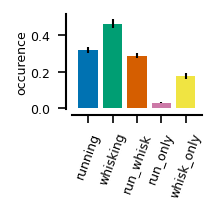

In [12]:
from scipy import stats
fig, ax = pt.figure()
for i, key in enumerate(RESULTS):
    print('%s : %.3f +/- %.3f or %.3f ' % (key, np.mean(RESULTS[key]), stats.sem(RESULTS[key]), np.std(RESULTS[key])))
    ax.bar([i], [np.mean(RESULTS[key])], yerr=[stats.sem(RESULTS[key])])
pt.set_plot(ax,
            xticks = range(i+1), xticks_labels=list(RESULTS.keys()),
            fontsize=6, xticks_rotation=70, ylabel='occurence')

In [47]:
LMIs, WMIs, WOMIs, n = [], [], [], 0

for i, f in enumerate(np.array(DATASET['folders'])[DATASET['with_whisking']]):
    with open(os.path.join(f, 'Analysis_Data.pickle'), 'rb') as F:
        data = pickle.load(F)
        if 'WMI dF' in data['table_data']:
            WMIs += list(np.array(data['table_data']['WMI dF'], dtype=float))
        else:
            print('no Whisking for: ', f)
        if 'WOMI dF' in data['table_data']:
            WOMIs += list(np.array(data['table_data']['WOMI dF'], dtype=float))
        else:
            print('no Whisking-Only for: ', f)
        if 'lmi' in data:
            LMIs += data['lmi']
            n+=1
        else:
            print('no Locomotion for: ', f)
            
print('N=%i sessions' % n )

no Whisking-Only for:  /Users/yann/DATA/Marcel_Data/2021.08.16/M_130/TSeries-08162021-1650-005
no Whisking-Only for:  /Users/yann/DATA/Marcel_Data/2021.02.25/M_106/TSeries-02252021-1557-005
N=85 sessions


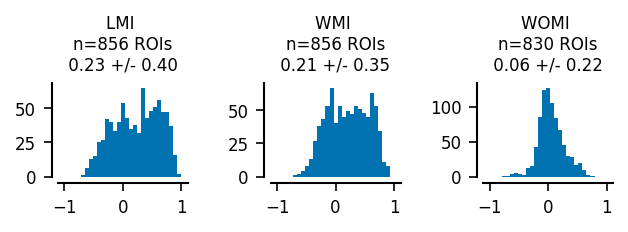

In [48]:
fig, AX = pt.figure(axes=(3,1))
for ax, MIs, title in zip(AX, [LMIs, WMIs, WOMIs], ['LMI', 'WMI', 'WOMI']):
    ax.hist(MIs, bins=np.linspace(-1,1,30))
    pt.set_plot(ax, xticks=[-1,0,1],
                title='%s \nn=%i ROIs\n %.2f +/- %.2f ' % (title, len(MIs), np.mean(MIs), np.std(MIs)))

In [56]:
import csv

with open('table.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    
    field = ["LMI", "WMI", "WOMI"]
    writer.writerow(field)
    
    for i in range(len(LMIs)):
        line = ''
        line += '%.6f, ' % LMIs[i] 
        line += '%.6f, ' % WMIs[i] 
        if i<(len(WOMIs)-1):
            line += '%.6f,' % WOMIs[i] 
        print(line)
        writer.writerow(line)

0.430963, 0.392161, -0.075777,
0.260016, 0.222361, -0.050626,
-0.043241, -0.036329, -0.079743,
-0.454143, -0.403963, -0.168654,
-0.410494, -0.356025, -0.150972,
-0.376821, -0.264068, 0.019349,
-0.375866, -0.346579, -0.164448,
-0.489477, -0.410370, -0.077950,
-0.436836, -0.345660, -0.017962,
0.308109, 0.368522, 0.314189,
0.189427, 0.199493, 0.094889,
-0.033908, -0.082772, -0.097674,
-0.104794, -0.088838, -0.019710,
-0.069716, -0.114637, -0.113242,
-0.021975, 0.001323, -0.019876,
-0.158353, -0.229208, -0.311131,
-0.033479, -0.109673, -0.166453,
0.364194, 0.376743, 0.464734,
0.712652, 0.715825, 0.582241,
0.600870, 0.603050, 0.585607,
0.667539, 0.671446, 0.549897,
0.591889, 0.597207, 0.647162,
0.478997, 0.481698, 0.574914,
0.459923, 0.461528, 0.569650,
0.468776, 0.471951, 0.401034,
0.614728, 0.616999, 0.489733,
0.230683, 0.227165, 0.218716,
0.362653, 0.363244, 0.388821,
0.280263, 0.281332, 0.365504,
0.340984, 0.328216, 0.279788,
0.353455, 0.328015, 0.180859,
0.593103, 0.564443, 0.373434,
0

In [53]:
import csv

with open('table.csv', 'w',) as file:
    file.w
    writer = csv.writer(file)
    
    field = ["LMI", "WMI", "WOMI"]
    writer.writerow(field)
    
    for i in range(len(LMIs)):
        line = ''
        line += '%.6f, ' % LMIs[i] 
        line += '%.6f, ' % WMIs[i] 
        if i<(len(WOMIs)-1):
            line += '%.6f,' % WOMIs[i] 
        print(line)
        writer.writerow(line)

0.43096270781414575